In [6]:
# huggingface transformer
#!git clone https://github.com/huggingface/transformers.git

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_hf = GPT2LMHeadModel.from_pretrained('gpt2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


torch.Size([1024, 768])


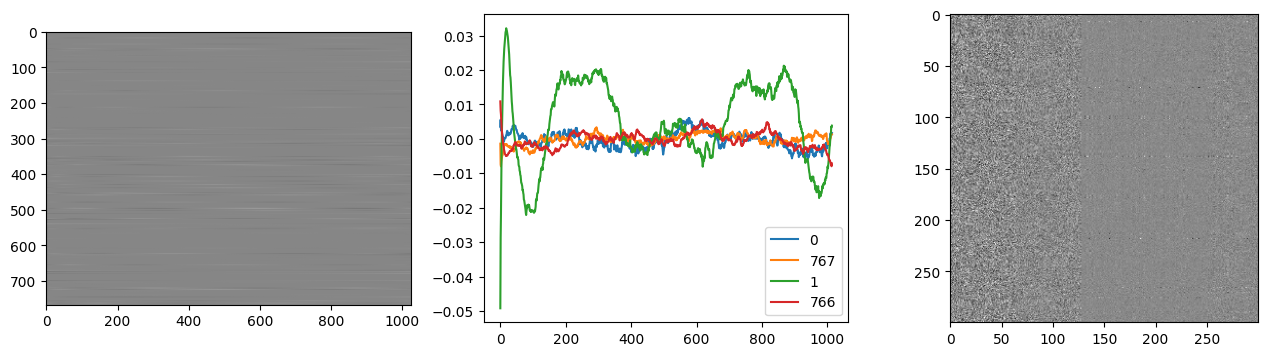

In [15]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(model_hf.state_dict()['transformer.wpe.weight'].T,cmap='gray')
plt.subplot(132)
print(model_hf.state_dict()['transformer.wpe.weight'].shape)
for col in range(2):
  plt.plot(model_hf.state_dict()['transformer.wpe.weight'][:,col].unfold(0,10,1).mean(-1), label=f'{col}')
  plt.plot(model_hf.state_dict()['transformer.wpe.weight'][:,767-col].unfold(0,10,1).mean(-1), label=f'{767-col}')
plt.legend()
plt.subplot(133)
plt.imshow(model_hf.state_dict()['transformer.h.1.attn.c_attn.weight'][:300,:300], cmap='gray')

In [16]:
print(model_hf)
sum = 0
for key,val in model_hf.state_dict().items():
  sum += val.nelement()
f'total {sum/1000000:.2f}m float32'

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


'total 163.04m float32'

In [3]:
''' hyper parameters '''
from dataclasses import dataclass

@dataclass
class GPTConfig():
  _attn_implementation_autoset:bool = True
  activation_function:str = 'gelu_new'
  architectures:tuple = ('GPT2LMHeadModel',)
  attn_pdrop:float = 0.1
  bos_token_id:int = 50256
  embed_pdrop:float = 0.1
  eos_token_id:int = 50256
  initializer_range: float = 0.02
  layer_norm_epsilon: float = 1e-5
  model_type: str = 'gpt2'
  n_ctx:int = 1024
  n_embed:int = 768
  n_head:int = 12
  n_inner:int = None
  n_layer:int = 12
  n_positions:int = 1024
  recorder_and_upcast_attn:bool = False
  resid_pdrop:float = 0.1
  scale_attn_by_inverse_layer_idx:bool = False
  scale_attn_weights:bool = True
  summary_activation:str = None
  summary_first_dropout:float = 0.1
  summary_proj_to_labels:bool = True
  summary_type:str = 'cls_idx'
  summary_use_proj:bool = True
  task_specific_params:dict = {
      'text-generation': {
          'do_sample': True,
          'max_length': 50
      }
  },
  torch_dtype:str = 'float32'
  use_cache:bool = True
  vocab_size:int = 50257

config = GPTConfig()
config

GPTConfig(_attn_implementation_autoset=True, activation_function='gelu_new', architectures=('GPT2LMHeadModel',), attn_pdrop=0.1, bos_token_id=50256, embed_pdrop=0.1, eos_token_id=50256, initializer_range=0.02, layer_norm_epsilon=1e-05, model_type='gpt2', n_ctx=1024, n_embed=768, n_head=12, n_inner=None, n_layer=12, n_positions=1024, recorder_and_upcast_attn=False, resid_pdrop=0.1, scale_attn_by_inverse_layer_idx=False, scale_attn_weights=True, summary_activation=None, summary_first_dropout=0.1, summary_proj_to_labels=True, summary_type='cls_idx', summary_use_proj=True, task_specific_params=({'text-generation': {'do_sample': True, 'max_length': 50}},), torch_dtype='float32', use_cache=True, vocab_size=50257)

In [8]:
''' GPT class
  model
  forward()
'''

class GPT2Attention(nn.Module):
  def __init__(self, config):
    super(GPT2Attention, self).__init__()
    self.n_head = config.n_head
    self.c_attn = nn.Conv1d(in_channels=config.n_embed, out_channels = 3*config.n_embed, kernel_size=1, stride=1)
    self.c_proj = nn.Conv1d(in_channels=config.n_embed, out_channels=config.n_embed, kernel_size=1, stride=1)
    self.attn_dropout = nn.Dropout(config.attn_pdrop)
    self.resid_dropout = nn.Dropout(config.resid_pdrop)

  def __call__(self, x):
    B,T,C = x.shape
    print('gpt2attention input', x.shape, x.dtype, self.c_attn.weight.shape, self.c_attn.bias.shape)

    x = self.c_attn(x.transpose(-1,-2)).transpose(-1,-2)
    print('gpt2attention c_attn',x.shape, x.dtype)
    q,k,v = x.split(self.c_attn.out_channels//3, dim=2)
    print('gpt2attention q,k,v', q.shape, q.dtype)
    q = q.reshape(B, self.n_head, T, C//self.n_head)
    k = k.reshape(B, self.n_head, T, C//self.n_head)
    v = v.reshape(B, self.n_head, T, C//self.n_head)
    x = F.softmax(q @ k.transpose(-1,-2) / np.sqrt(C//self.n_head), dim=-1) @ v
    x = x.transpose(-2,-3).reshape(B,T,C)
    x = self.attn_dropout(x)
    x = self.c_proj(x.transpose(-1,-2)).transpose(-1,-2)
    x = self.resid_dropout(x)
    return x

class GPT2MLP(nn.Module):
  def __init__(self, config):
    super(GPT2MLP, self).__init__()
    self.c_fc = nn.Conv1d(in_channels=config.n_embed, out_channels=4*config.n_embed, kernel_size=1, stride=1)
    self.c_proj = nn.Conv1d(in_channels=4*config.n_embed, out_channels=config.n_embed, kernel_size=1, stride=1)
    self.act = nn.GELU()
    self.dropout = nn.Dropout(config.resid_pdrop)

  def __call__(self, x):
    print('gpt2mlp input', x.shape, x.dtype)
    x = self.c_fc(x.transpose(-1,-2)).transpose(-1,-2)
    print('gpt2mlp c_fc', x.shape, x.dtype)
    x = self.c_proj(self.act(x).transpose(-1,-2)).transpose(-1,-2)
    print('gpt2mlp c_proj', x.shape, x.dtype)
    x = self.dropout(x)
    return x

class GPT2Block(nn.Module):
  def __init__(self, config):
    super(GPT2Block, self).__init__()
    self.ln_1 = nn.LayerNorm(config.n_embed, eps=config.layer_norm_epsilon)
    self.attn = GPT2Attention(config)
    self.ln_2 = nn.LayerNorm(config.n_embed, eps = config.layer_norm_epsilon)
    self.mlp = GPT2MLP(config)

  def __call__(self, x):
    x = x + self.attn(self.ln_1(x)) #B,T,C -> #B,T,C
    print('attn', x.shape, x.dtype)
    x = x + self.mlp(self.ln_2(x)) #B,T,C
    print('mlp', x.shape, x.dtype)
    return x

class GPT2Model(nn.Module):
  def __init__(self, config):
    super(GPT2Model, self).__init__()
    self.wte = nn.Embedding(config.vocab_size, config.n_embed)
    self.wpe = nn.Embedding(config.n_positions, config.n_embed)
    self.drop = nn.Dropout(config.embed_pdrop, inplace=False)
    self.h = nn.ModuleList([GPT2Block(config) for _ in range(config.n_layer)])
    self.ln_f = nn.LayerNorm(config.n_embed, eps=config.layer_norm_epsilon)

  def __call__(self, x):
    print('x', x.shape,x.dtype)
    te = self.wte(x) #batch_size,n_ctx -> batch_size,n_ctx,n_embed
    print('te', te.shape,te.dtype)
    pe = self.wpe(torch.arange(x.shape[1])) # n_ctx,n_embed
    print('pe',pe.shape,pe.dtype)
    x = self.drop(te + pe) # batch_size,n_ctx,n_embed
    print('te+pe', x.shape, x.dtype)
    for block in self.h:
      x = block(x) # batch_size,n_ctx,n_embed
    x = self.ln_f(x) # batch_size,n_ctx,vocab_size
    print('ln_f', x.shape, x.dtype)
    return x

class GPT2LMHeadModel(nn.Module):
  def __init__(self, config):
    super(GPT2LMHeadModel, self).__init__()
    self.transformer = GPT2Model(config)
    self.lm_head = nn.Linear(config.n_embed, config.vocab_size, bias=False)

  def __call__(self, x, y=None):
    x = self.transformer(x)
    x = self.lm_head(x)
    print('lm_head', x.shape, x.dtype)
    return x

# unit test
model = GPT2LMHeadModel(config)
model(torch.zeros((1,config.n_ctx),dtype=torch.int32).repeat(2,1) + config.bos_token_id)


x torch.Size([2, 1024]) torch.int32
te torch.Size([2, 1024, 768]) torch.float32
pe torch.Size([1024, 768]) torch.float32
te+pe torch.Size([2, 1024, 768]) torch.float32
gpt2attention input torch.Size([2, 1024, 768]) torch.float32 torch.Size([2304, 768, 1]) torch.Size([2304])
gpt2attention c_attn torch.Size([2, 1024, 2304]) torch.float32
gpt2attention q,k,v torch.Size([2, 1024, 768]) torch.float32
attn torch.Size([2, 1024, 768]) torch.float32
gpt2mlp input torch.Size([2, 1024, 768]) torch.float32
gpt2mlp c_fc torch.Size([2, 1024, 3072]) torch.float32
gpt2mlp c_proj torch.Size([2, 1024, 768]) torch.float32
mlp torch.Size([2, 1024, 768]) torch.float32
gpt2attention input torch.Size([2, 1024, 768]) torch.float32 torch.Size([2304, 768, 1]) torch.Size([2304])
gpt2attention c_attn torch.Size([2, 1024, 2304]) torch.float32
gpt2attention q,k,v torch.Size([2, 1024, 768]) torch.float32
attn torch.Size([2, 1024, 768]) torch.float32
gpt2mlp input torch.Size([2, 1024, 768]) torch.float32
gpt2mlp c_fc

tensor([[[-0.5893,  0.3929, -0.2518,  ...,  1.3397,  0.0622,  0.2054],
         [-0.5323,  0.1701,  0.1920,  ..., -0.2515, -0.8740,  0.1708],
         [ 0.0316,  0.6598, -0.7528,  ...,  0.7546, -0.6295,  0.1905],
         ...,
         [ 0.3159,  0.5229, -0.3446,  ..., -0.2403, -0.3507,  0.0643],
         [-0.4935,  0.1795, -0.3483,  ...,  0.7391, -0.4336, -0.4256],
         [-0.5304,  0.3733, -0.3850,  ...,  0.8176,  0.3423,  0.3283]],

        [[-0.6614, -0.0216, -0.9986,  ...,  0.5592,  0.3400, -0.1305],
         [-0.4989,  0.1975,  0.1890,  ..., -0.2216, -0.4155, -0.0487],
         [ 0.0860,  1.2414, -0.8139,  ...,  0.2950, -0.8889,  0.0078],
         ...,
         [ 0.5557,  0.6863, -0.4578,  ...,  0.3209,  0.3936,  0.2363],
         [-0.4334,  0.3717, -0.7706,  ...,  0.4065, -0.6718, -0.8755],
         [-0.1188,  0.3979, -0.6025,  ...,  0.5563, -0.4147, -0.0237]]],
       grad_fn=<UnsafeViewBackward0>)

In [45]:
conv = nn.Conv1d(in_channels=2, out_channels=3, kernel_size=1, stride=1)
conv.weight, conv.bias
conv(torch.tensor([[2.,1.0,3],[1.,1.,2]]))

tensor([[-1.4943, -0.9914, -1.9573],
        [ 0.3557,  0.4383,  0.2387],
        [-1.9030, -1.2654, -2.8524]], grad_fn=<SqueezeBackward1>)

In [ ]:
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)
total 163.04m float32